<a href="https://colab.research.google.com/github/rainmaker29/Introduction-to-Tensorflow/blob/master/lr_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

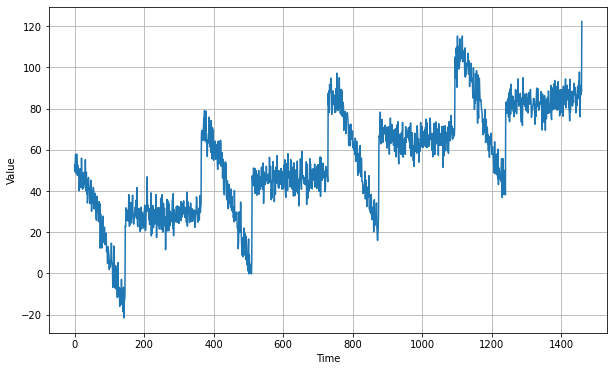

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

  
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
#Linear model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 0s 13ms/step - loss: 46.0576 - mae: 47.1784 - val_loss: 23.2230 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 11.7945 - mae: 12.4017 - val_loss: 10.8016 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 10.1228 - mae: 10.6947 - val_loss: 9.2102 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 9.7176 - mae: 10.2898 - val_loss: 9.0811 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 9.6592 - mae: 10.1940 - val_loss: 8.9231 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 9.6531 - mae: 10.0706 - val_loss: 9.3132 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 9.6011 - mae: 10.0561 - val_loss: 8.7081 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - l

In [7]:
#using the best learning rate

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 67.8256 - mae: 68.1863 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 52.2258 - mae: 52.8561 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 34.5809 - mae: 35.1446 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 17.5133 - mae: 18.1484 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 8.3969 - mae: 8.9488 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 8.1147 - mae: 8.4627 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8553 - mae: 8.4035 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 7.9013 - mae: 8.3609 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8796 - mae: 8.3014 - lr: 1.84

(1e-06, 0.001, 0.0, 20.0)

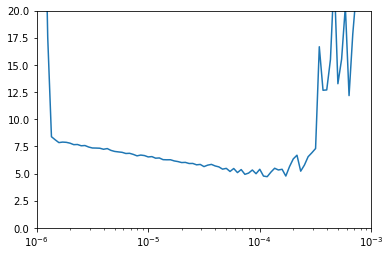

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 10ms/step - loss: 46.0576 - mae: 47.1784 - val_loss: 23.2230 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 11.7945 - mae: 12.4017 - val_loss: 10.8016 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 10.1228 - mae: 10.6947 - val_loss: 9.2102 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 9.7176 - mae: 10.2898 - val_loss: 9.0811 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 9.6592 - mae: 10.1940 - val_loss: 8.9231 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 9.6531 - mae: 10.0706 - val_loss: 9.3132 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 9.6011 - mae: 10.0561 - val_loss: 8.7081 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - l

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [13]:
lin_forecast.shape

(461,)

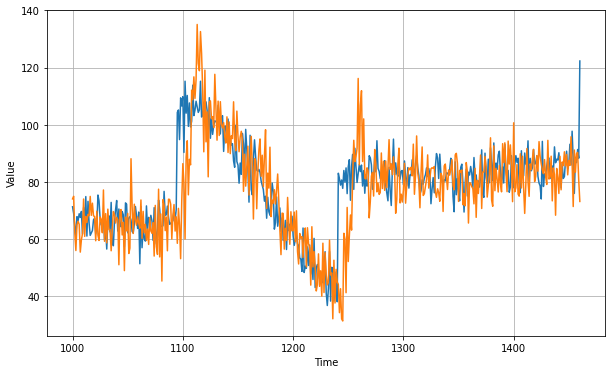

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [15]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

8.552396

In [0]:
#Using a dense model

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  
#   keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
#   keras.layers.Dense(10, activation="relu"),
#   keras.layers.Dense(1)


  keras.layers.Dense(50, activation="relu"),
  keras.layers.Dense(50, activation="relu"),
  keras.layers.Dense(25, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 50.1032 - mae: 50.1814 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 48.2768 - mae: 48.6280 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 46.2431 - mae: 46.7352 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 43.9350 - mae: 44.6313 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 41.7243 - mae: 42.3027 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 39.3014 - mae: 39.7179 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 36.3001 - mae: 36.8656 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 33.1564 - mae: 33.6977 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 29.7372 - mae: 30.2764 

(1e-07, 0.005, 0.0, 30.0)

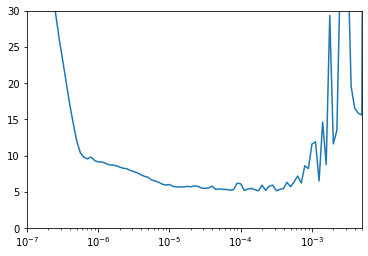

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  
#   keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
#   keras.layers.Dense(10, activation="relu"),
#   keras.layers.Dense(1)


  keras.layers.Dense(50, activation="relu"),
  keras.layers.Dense(50, activation="relu"),
  keras.layers.Dense(25, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 11ms/step - loss: 43.8546 - mae: 44.0983 - val_loss: 71.3691 - val_mae: 71.8993
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 32.9158 - mae: 33.5223 - val_loss: 43.9616 - val_mae: 44.3598
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 13.0511 - mae: 13.6768 - val_loss: 9.6376 - val_mae: 9.9598
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 7.8676 - mae: 8.4260 - val_loss: 7.1147 - val_mae: 7.5937
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 7.4653 - mae: 8.0010 - val_loss: 6.9349 - val_mae: 7.4171
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 7.2967 - mae: 7.8009 - val_loss: 7.1599 - val_mae: 7.5532
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 7.1269 - mae: 7.6359 - val_loss: 6.5902 - val_mae: 7.1910
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss:

In [0]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

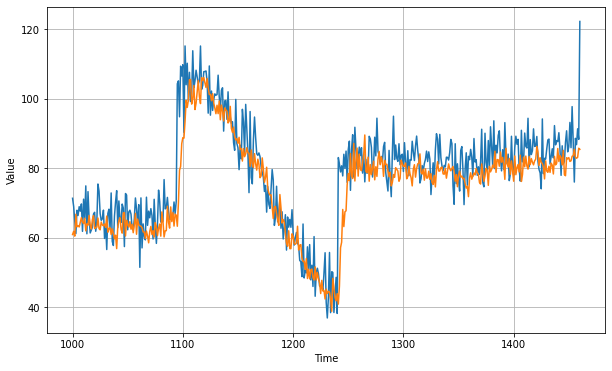

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [28]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.80112